# 3.1 Coding the self-attention mechanism

## I primi modelli di NLP per la traduzione: RNN Encoder-Decoder e il problema delle frasi lunghe

I primi modelli di Natural Language Processing (NLP) utilizzati per la traduzione da una lingua all'altra incontravano difficoltà significative nel gestire frasi molto lunghe. Inizialmente, si utilizzavano reti neurali ricorrenti (RNN) con una struttura **Encoder-Decoder**, simile a quella dei modelli moderni. Questa architettura era composta da due distinte reti ricorrenti:

*   **Encoder**: Aveva il compito di leggere la frase di input e condensare il suo significato in un **vettore di stato nascosto** (hidden state). Questo vettore rappresentava una sorta di "sommario" dell'intera frase di input.
*   **Decoder**: Riceveva in input lo stato nascosto dell'encoder e generava sequenzialmente la traduzione nella lingua di output.

Tuttavia, questa struttura iniziale presentava un limite cruciale: non riusciva a gestire e tradurre correttamente frasi particolarmente lunghe e complesse. Il motivo principale era che il singolo vettore di stato nascosto generato dall'encoder alla fine del processo non era sufficientemente informativo per racchiudere tutte le sfumature contestuali necessarie per una traduzione accurata di frasi estese.

Per superare questa limitazione, venne introdotto il primo meccanismo di **attenzione (attention mechanism)**. L'idea innovativa era che, ad ogni passo del decoder, la rete non si basasse esclusivamente sull'output del layer precedente e sull'ultimo stato nascosto dell'encoder, ma potesse anche accedere e selezionare **dinamicamente** uno o più stati nascosti generati dall'encoder durante l'elaborazione della frase di input. Questo permetteva al decoder di "concentrarsi" sulle parti più rilevanti della frase originale durante la generazione della traduzione.


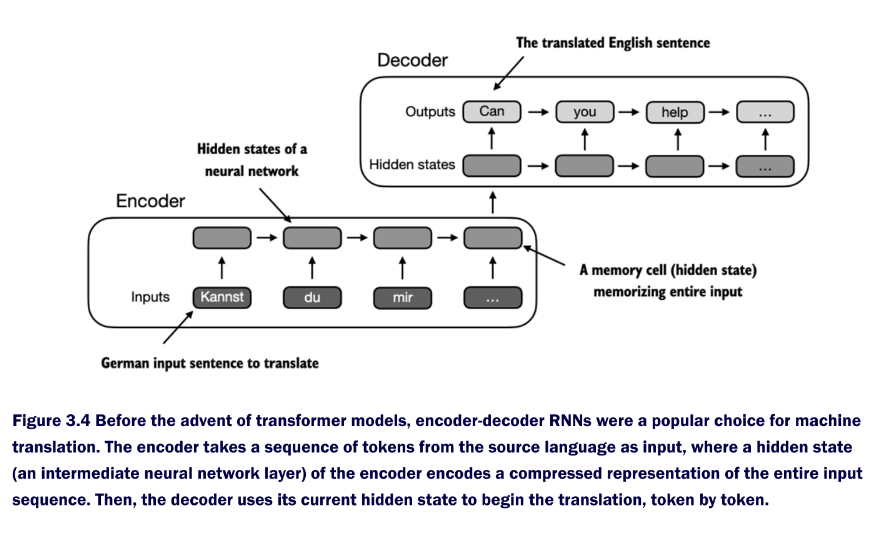

## L'evoluzione verso i Transformer: Abbandonare la ricorrenza per l'attenzione

Successivamente, i ricercatori si resero conto che era possibile sfruttare il meccanismo di attenzione in modo ancora più potente, rendendo superflua l'architettura ricorrente delle RNN per molti compiti di traduzione e non solo. Da questa intuizione nacquero i **Transformer**.

I Transformer si basano interamente sul meccanismo di attenzione, in particolare sulla **Self-Attention** (auto-attenzione), che permette al modello di pesare l'importanza delle diverse parole nella sequenza di input (e di output) durante l'elaborazione. Questo approccio non sequenziale, a differenza delle RNN che elaborano le parole una alla volta, consente ai Transformer di parallelizzare i calcoli e catturare dipendenze a lunga distanza all'interno delle frasi in modo molto più efficiente e performante.

In [ ]:
# example input (embedding X)
import torch
inputs = torch.tensor(
[[0.43, 0.15, 0.89], # Your(x^1)
[0.55, 0.87, 0.66], # journey(x^2)
[0.57, 0.85, 0.64], # starts(x^3)
[0.22, 0.58, 0.33], # with(x^4)
[0.77, 0.25, 0.10], # one(x^5)
[0.05, 0.80, 0.55]] # step(x^6)
)

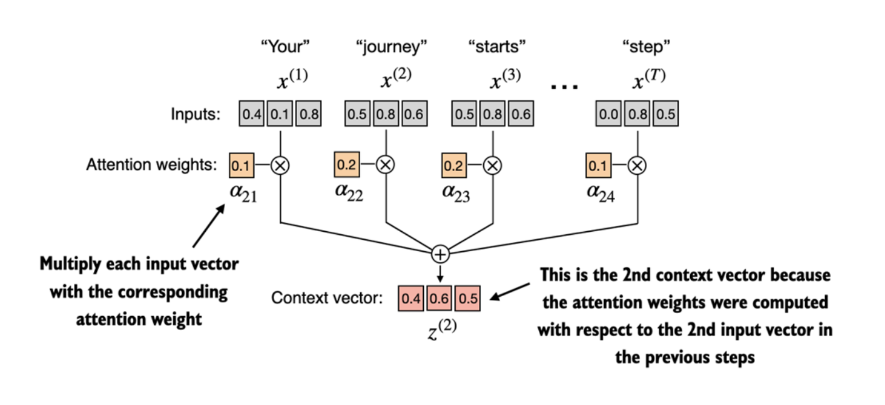

L'operazione di self-attention viene definita come:

$$Z = \text{Softmax}(XX^T)X$$

Questa operazione può essere vista come un processo in due fasi:

1.  **Calcolo delle similarità**: Viene calcolata una matrice di similarità tra tutti i vettori di input ($XX^T$). Questa matrice indica quanto ogni parola è correlata alle altre parole nella sequenza.
2.  **Somma pesata**: La matrice di similarità (normalizzata tramite Softmax) viene utilizzata come pesi per sommare i vettori di input originali ($X$). Ogni riga della matrice risultante $Z$ rappresenta il nuovo embedding di una parola, ottenuto come somma pesata di tutti i vettori di input, dove i pesi riflettono l'importanza delle altre parole per quella specifica parola.

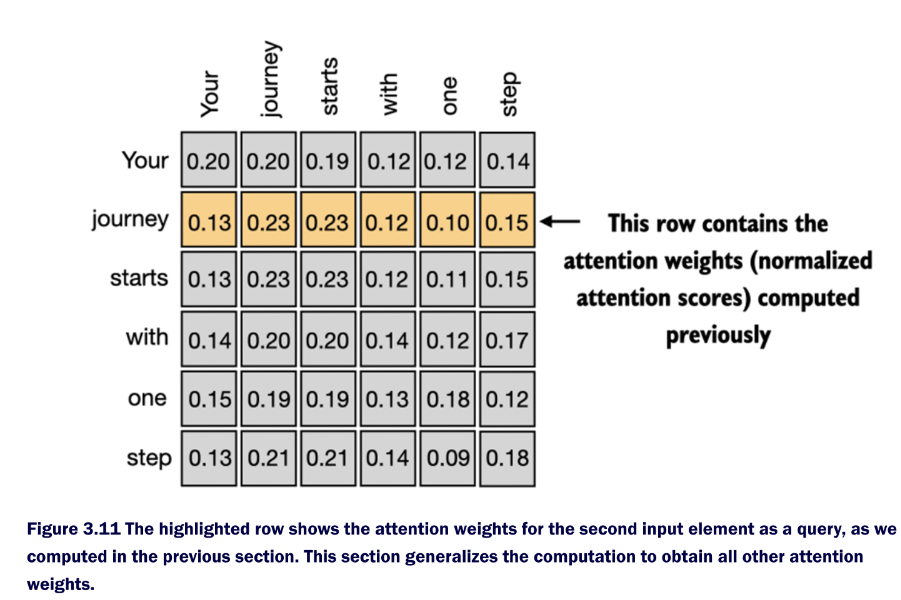

Questa e la matrice di similarita $XX^T$

In [ ]:
similaryty_matrix = inputs@inputs.T
print("XX^T: \n", similaryty_matrix)

In [ ]:
weight_matrix = torch.softmax(similaryty_matrix, dim = -1)

print("Softmax(XX^T): \n", weight_matrix)

In [ ]:
# normalizzazione della softmax
print("somma delle righe: ", weight_matrix.sum(dim=-1))

La funzione softmax normalizza le similarita di una parola rispetto a tutte le altre dell'input, in maniera tale che gli *attention weights* calcolati siano positivi. Questo e importante per:
1. Interpretare in maniera trasparente quali siano le parole piu importanti (importanza relativa) per il nuovo embedding di una parola fissata.
2. Stabilita numerica dell'operazione
3. Proprieta comode del gradiente della funzione softmax, che saranno utili durante il training

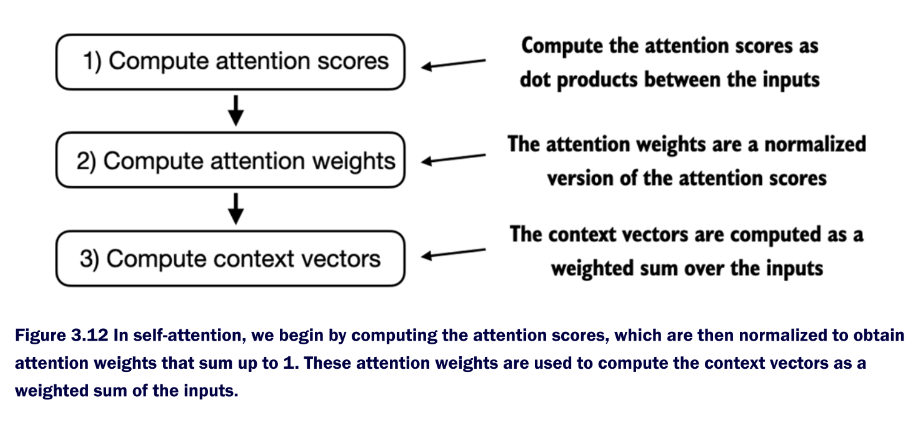

In [ ]:
context_vec = weight_matrix@inputs
print("Z: \n", context_vec)

# 3.2 Self-attention with trainable weights

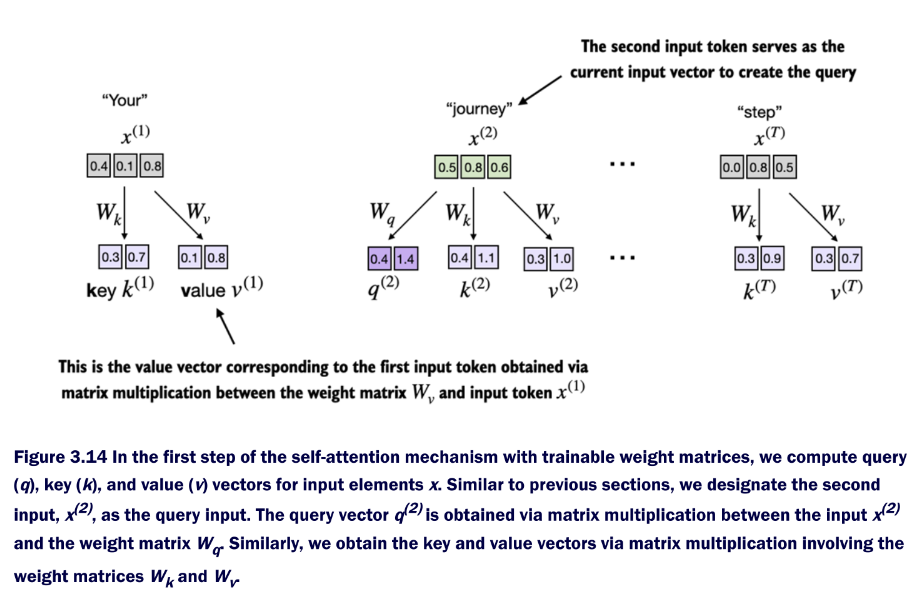

L'operazione di self-attention finora non ha parametri allenabili. Per introdurre l'apprendimento, usiamo tre matrici di proiezione allenabili: $W_q$ (query), $W_k$ (key) e $W_v$ (value).

Queste matrici servono a due scopi:

1.  **Gestire l'asimmetria del linguaggio**: Proiettando l'input in spazi separati, il modello distingue i ruoli delle parole, riflettendo l'asimmetria del linguaggio.
2.  **Rendere il modello allenabile**: $W_q$, $W_k$ e $W_v$ sono parametri appresi durante l'addestramento, permettendo al modello di ottimizzare il calcolo delle relazioni di attenzione.

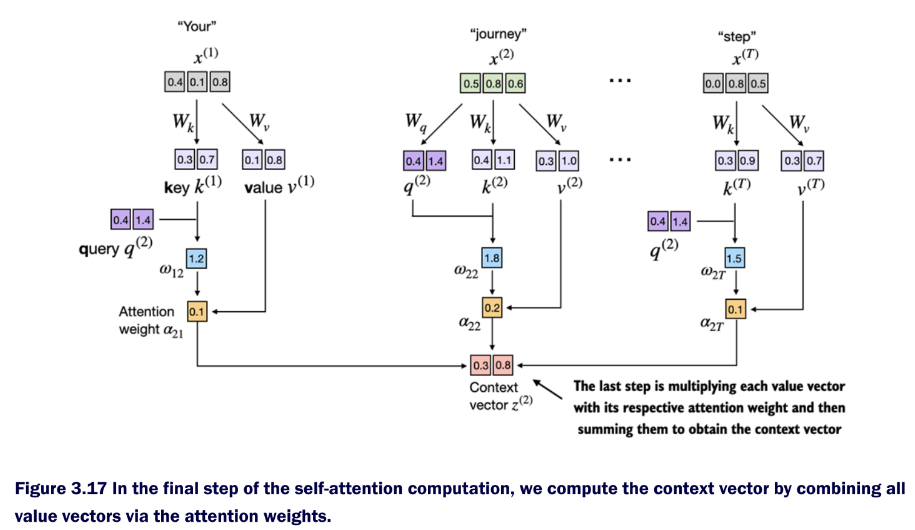

In [ ]:
d_in, d_out = 3,2

torch.manual_seed(123)
W_query = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_key= torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_value = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)

Vediamo come funziona l'operazione nel caso di un solo vettore di embedding input.

In [ ]:
query_2 = inputs[1]@W_query # proiezione nello spazio query

In [ ]:
keys = inputs @ W_key # proiezione nello spazio key
values = inputs @ W_value # p. nelo spazio values
print("keys.shape:", keys.shape)
print("values.shape:", values.shape)

In [ ]:
attn_scores_2 = query_2 @ keys.T # All attention scores for given query
print(attn_scores_2)

In [ ]:
d_k = keys.shape[-1]
attn_weights_2 = torch.softmax(attn_scores_2/ d_k**0.5, dim = -1)
print(attn_weights_2)

In [ ]:
value_2 = attn_weights_2@values
print(value_2)

Adesso facciamo la stessa cosa ma per tutto l'input. Ovvero:

$$V_2 = \text{Softmax}(\frac{QK^T}{\sqrt{d}})V_1$$
Dove:
1. $W_k,W_v,W_q \in M(d,d)$
2. $V_i=XW_v^{(i)}$, $Q = XW_q$, $K=XW_k$
3. $X \in M(N,d)$

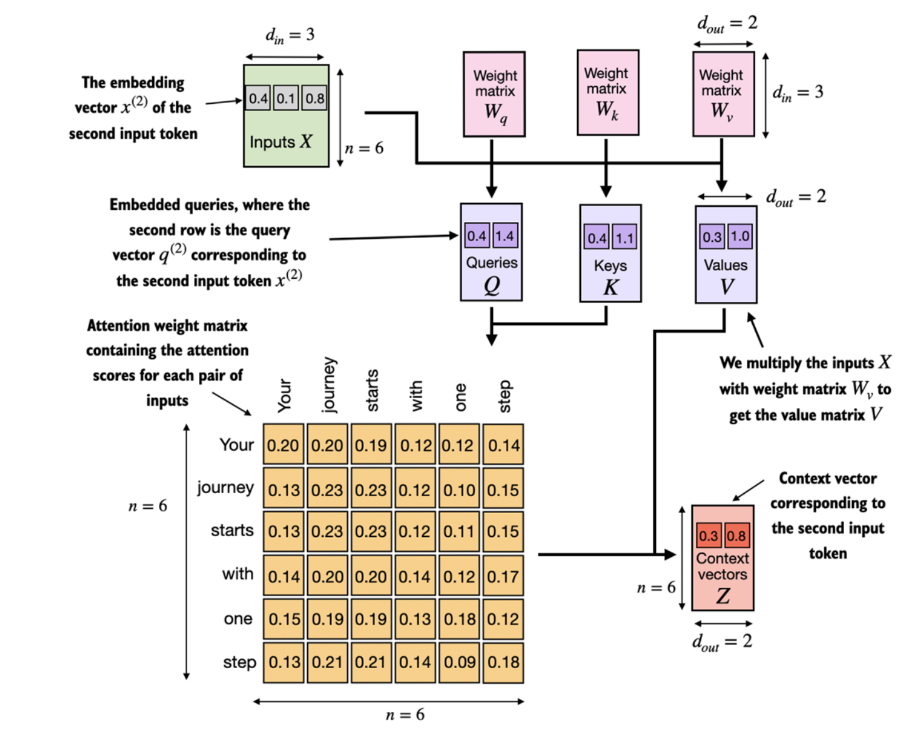

In [ ]:
querys = inputs@W_query
print("Q: \n", querys)

In [ ]:
attn_weights = querys @ keys.T
print("QK^T: \n", attn_weights)

In [ ]:
values_2 = torch.softmax(attn_weights/d_k**0.5, dim = -1) @ values
print("V_2= Softmax( QK^T/sqrt(d) ) V_1:  \n", values_2)

## Implementaizone in PyTorch

Adesso sfruttiamo l'API di PyTorch per creare un layer per una futura rete neurale che asgisca esattamente nel modo in cui vogliamo.

In [ ]:
import torch.nn as nn
class SelfAttention_v1(nn.Module):
  def __init__(self, d_in, d_out):
    super().__init__()
    self.d_out = d_out
    self.d_in = d_in
    self.W_query = nn.Parameter(torch.rand(d_in,d_out))
    self.W_key = nn.Parameter(torch.rand(d_in,d_out))
    self.W_value = nn.Parameter(torch.rand(d_in,d_out))

  def forward(self, x):
    keys = x @ self.W_key
    values = x @ W_value
    queries = x @ W_query
    attn_scores = queries @ keys.T
    attn_weights = torch.softmax(
        attn_scores/d_out**0.5, dim = -1
    )
    context_vec = attn_weights @ values
    return context_vec

In [ ]:
torch.manual_seed(123)
sa_v1 = SelfAttention_v1(3,2)
print(sa_v1(inputs))

Possiamo sfruttare ulteriormente PyTorch utilizzando la classe `Linear()`. Questa permette di istanziare una layer lineare con un'inizializzazione dei pesi che permette di ottenere un buon comportamento del modello durante la fase di training.  

In [ ]:
class SelfAttention_v2(nn.Module):
  def __init__(self, d_in, d_out, qkv_bias=False):
    super().__init__()
    self.d_out = d_out
    self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
  def forward(self, x):
    keys = self.W_key(x)
    queries = self.W_query(x)
    values = self.W_value(x)
    attn_scores = queries @ keys.T
    attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
    context_vec = attn_weights @ values
    return context_vec

In [ ]:
torch.manual_seed(789)
sa_v2 = SelfAttention_v2(d_in, d_out)
print(sa_v2(inputs))

# 3.3 Hiding future words with masked attention

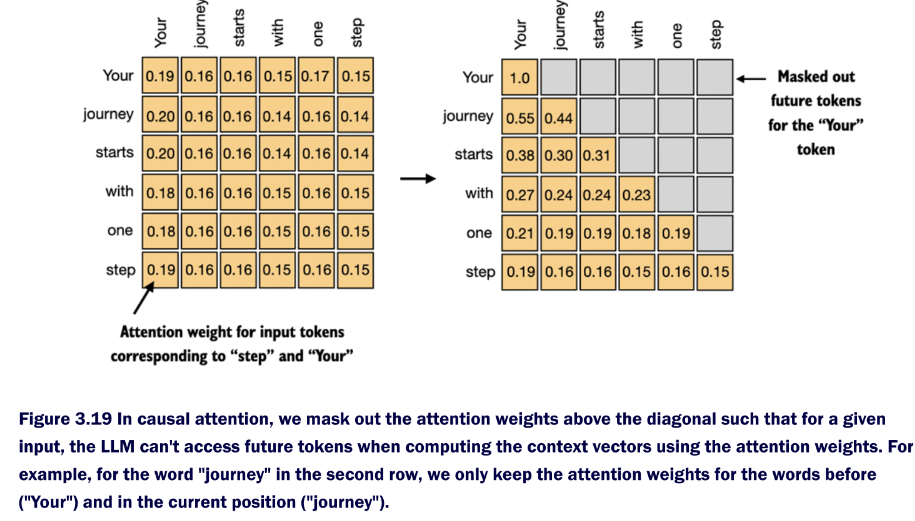

L'operazione di mascheramento (masking) della matrice di similarità diventa cruciale durante l'addestramento dei modelli generativi. Quando il modello deve generare testo sequenzialmente, parola per parola, è fondamentale impedirgli di "vedere" le parole future nella sequenza di input. Mascherando opportunamente la matrice di similarità, ci assicuriamo che il modello si basi solo sulle parole precedenti per predire la successiva, simulando il processo di generazione reale e impedendogli di "barare".

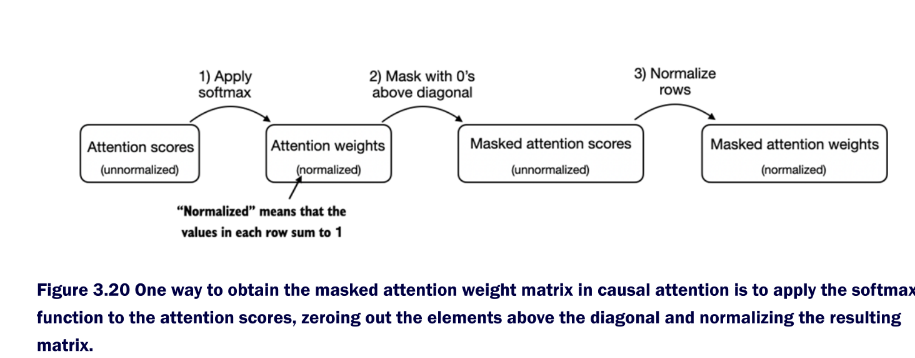

In [ ]:
queries = sa_v2.W_query(inputs)
#A
keys = sa_v2.W_key(inputs)
attn_scores = queries @ keys.T
attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=1)
print(attn_weights)

In [ ]:
context_length = attn_scores.shape[0]
mask_simple = torch.tril(torch.ones(context_length, context_length))
print(mask_simple)

In [ ]:
masked_simple = attn_weights*mask_simple
print(masked_simple)

In [ ]:
row_sums = masked_simple.sum(dim=1, keepdim=True)
masked_simple_norm = masked_simple / row_sums
print(masked_simple_norm)

Dopo aver mascherato e rinormalizzato con la softmax la matrice dei pesi, possiamo essere sicuri di aver annullato la fuga di informazioni dovuta a parole succesive a quelle considerate dalla rete. Tuttavia e possibile sfruttare le proprieta della softmax per ottenere lo stesso risultato in meno passaggi.

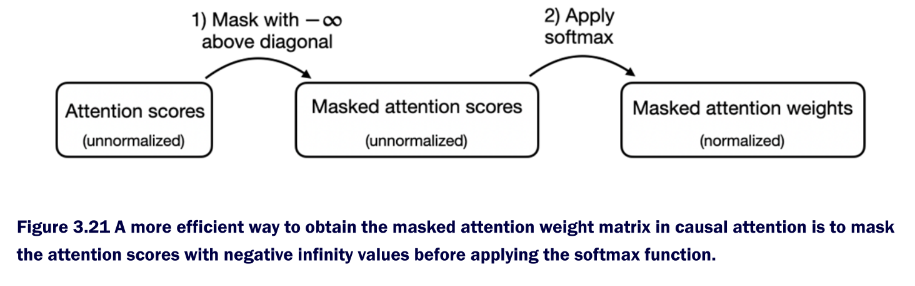

In [ ]:
mask = torch.triu(torch.ones(context_length, context_length), diagonal=1)
masked = attn_scores.masked_fill(mask.bool(), -torch.inf)
print(masked)

In [ ]:
attn_weights = torch.softmax(masked / keys.shape[-1]**0.5, dim=1)
print(attn_weights)

## Implementing Dropout

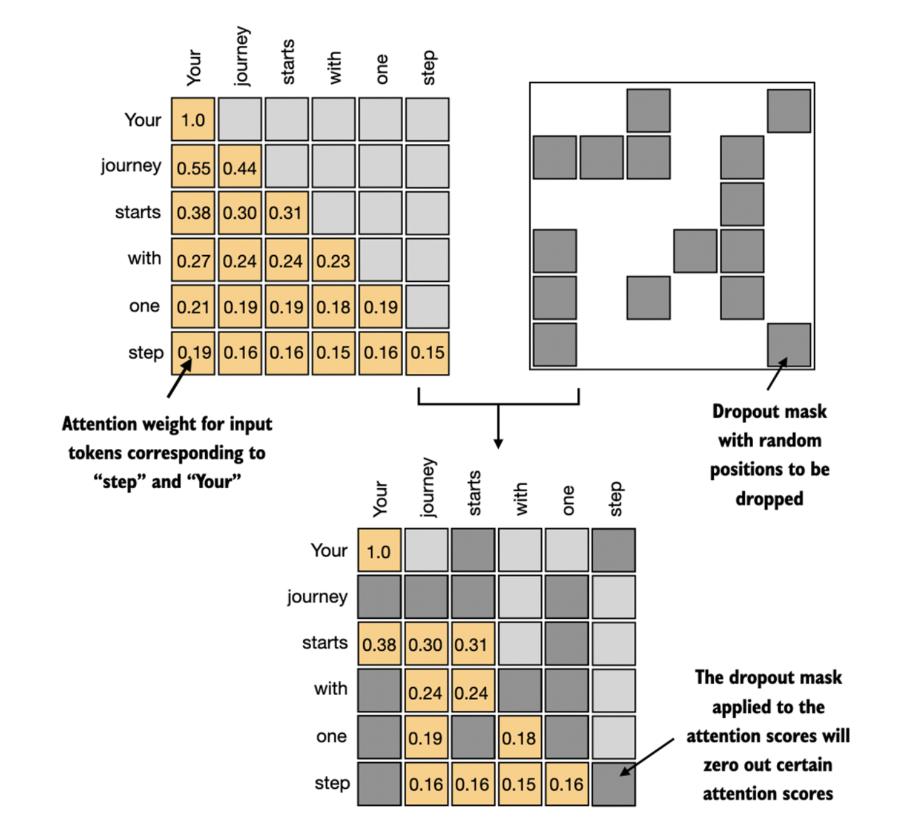

Un ulteriore miglioramento che possiamo apportare al nostro layer e quello del dropout. L'idea e quella di amputare certi collegamenti durante l'allenamento, in maniera tale da evitare che la rete faccia affidamento solamente su un loro sottinsieme.

Per fare questo in maniera efficiente possiamo sfruttare l'API di PyTorch che fornisce il layer `Dropout(r)`, dove $r$ corrisponde alla percentuale di pesi mascherati a caso durante l'allenamento.

In [ ]:
# esempio
torch.manual_seed(123)
dropout = torch.nn.Dropout(0.5) # generazione della msachera di Dropout
example = torch.ones(6, 6) # i pesi rimanenti vengono scalati per assicurare equilibrio sui pesi e mantenere invariato il funzionamento della rete
print(dropout(example))

In [ ]:
# applicazione allamatrice dei pesi
torch.manual_seed(123)
print(dropout(attn_weights))

## Implementazione in PyTorch

In [ ]:
# assicurazione che il layer possa gestire i batch (piu input alla volta) forniti dal DataLoader che abbiamo create nel capitolo 2
batch = torch.stack((inputs, inputs), dim=0)
print(batch.shape)

In [ ]:
class CausalAttention(nn.Module):
  def __init__(self, d_in, d_out, context_length, dropout, qkv_bias=False):
    super().__init__()
    self.d_out = d_out
    self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.dropout = nn.Dropout(dropout)
    self.register_buffer(
    'mask',
    torch.triu(torch.ones(context_length, context_length),
    diagonal=1)
    ) # handling memory in GPU/CPU training scenarios

  def forward(self, x):
    b, num_tokens, d_in = x.shape
    keys = self.W_key(x) # K
    queries = self.W_query(x) # Q
    values = self.W_value(x) # V
    attn_scores = queries @ keys.transpose(1, 2) # transpose dimension 1 and 2 of the 3D input tensor we are processing
    attn_scores.masked_fill_(
      self.mask.bool()[:num_tokens, :num_tokens], -torch.inf
      ) # masking
    attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1) # normalizzazione della matrice dei pesi mascherata
    attn_weights = self.dropout(attn_weights) # regolarizzazione tramite dropout
    context_vec = attn_weights @ values
    return context_vec

In [ ]:
torch.manual_seed(123)
context_length = batch.shape[1]
ca = CausalAttention(d_in, d_out, context_length, 0.0) # senza dropout
context_vecs = ca(batch)
print("context_vecs.shape:", context_vecs.shape)

# 3.4 Multi-head attention

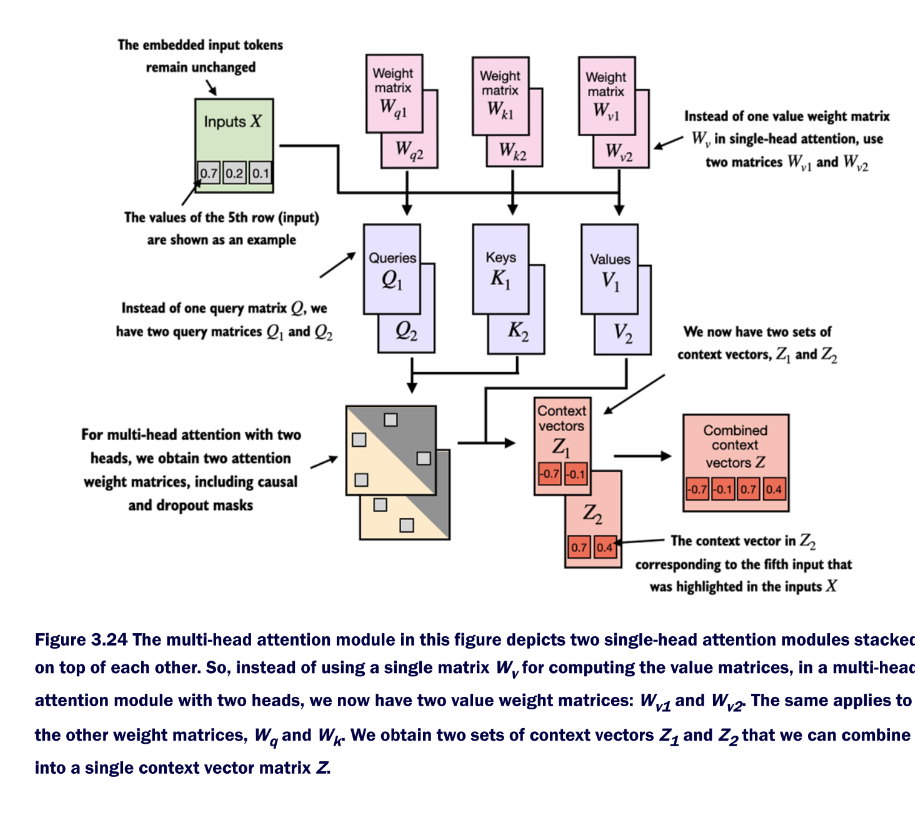

## Implementazione naive

In [ ]:
class MultiHeadAttentionWrapper(nn.Module):
  def __init__(self, d_in, d_out, context_length,
  dropout, num_heads, qkv_bias=False):
    super().__init__()
    self.heads = nn.ModuleList(
      [CausalAttention(d_in, d_out, context_length, dropout, qkv_bias)
      for _ in range(num_heads)] # tramite un ciclo vengono create piu attention-head
      )

  def forward(self, x): # le facciamo operare in serie tramite un altro ciclo
    return torch.cat([head(x) for head in self.heads], dim=-1) # i risultati delle varie attention-head vengono concatenate orizzontalmente

In [ ]:
torch.manual_seed(123)
context_length = batch.shape[1] # This is the number of tokens
d_in, d_out = 3, 2
mha = MultiHeadAttentionWrapper(d_in, d_out, context_length, 0.0, num_heads=2)
context_vecs = mha(batch)
print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

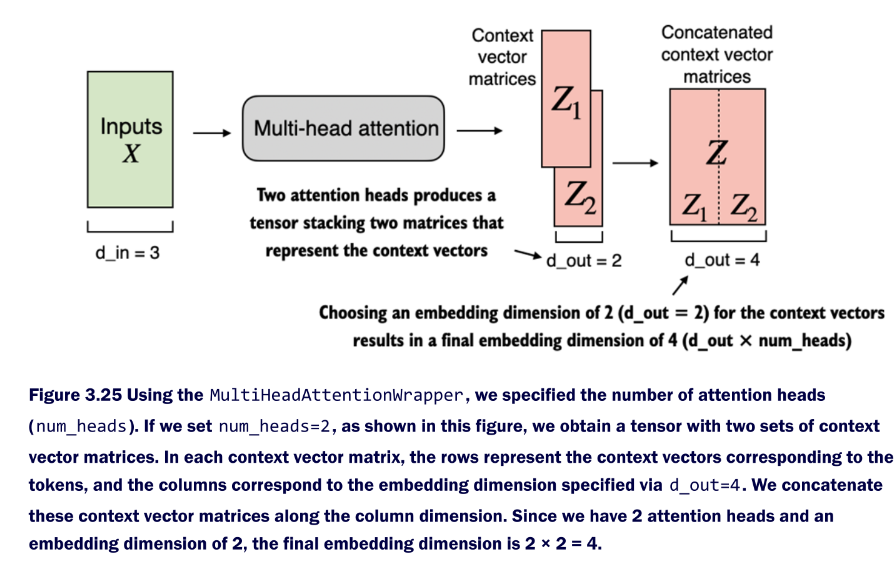

Alla fine otteniamo un nuovo embedding $Z$ con un numero di dimensioni pari a $n_{heads} \cdot d_{out}$.

Questo nuovo embedding può essere visto come una proiezione delle parole in input in uno spazio multidimensionale più ampio, capace di catturare un maggior numero di correlazioni tra i dati di input.

Il funzionamento di un modulo di multi-head attention è analogo a quello di un modulo convoluzionale con più mappe: ogni "attention-head" cattura una sfumatura specifica della frase di input, e l'embedding finale $Z$ racchiude la somma di tutte queste sfumature.

## Implementazione efficiente

L'implementazione di prima sfruttava dei cicli for che non sono per niente efficienti. Per ottenere una classe efficiente possiamo pensare di definire un classe `MultiHeadAttention()`

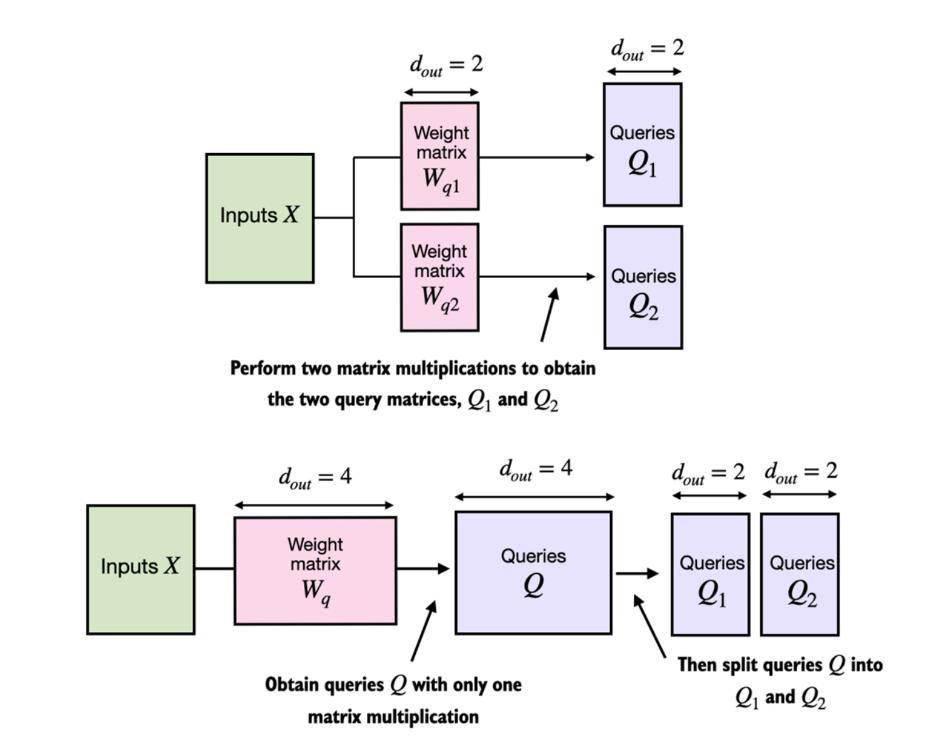

In [ ]:
class MultiHeadAttention(nn.Module):

  def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):

    super().__init__()
    assert d_out % num_heads == 0, "d_out must be divisible by num_heads"

    self.d_out = d_out
    self.num_heads = num_heads
    self.head_dim = d_out // num_heads

    self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.out_proj = nn.Linear(d_out, d_out) # linear layer to combine head outputs

    self.dropout = nn.Dropout(dropout) # layer di dropout

    self.register_buffer(
    'mask',
    torch.triu(torch.ones(context_length, context_length), diagonal=1)
    )

  def forward(self, x):
    b, num_tokens, d_in = x.shape
    # [b, num_tokens, d_out]
    keys = self.W_key(x)
    queries = self.W_query(x)
    values = self.W_value(x)

    # [b, num_tokens, num_heads, head_dim]
    keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
    values = values.view(b, num_tokens, self.num_heads, self.head_dim)
    queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

    # [b, num_heads, num_tokens, head_dim]
    keys = keys.transpose(1, 2)
    queries = queries.transpose(1, 2)
    values = values.transpose(1, 2) # Q
    attn_scores = queries @ keys.transpose(2, 3) # K^T

    # causal masking
    mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
    attn_scores.masked_fill_(mask_bool, -torch.inf)

    # normalization
    attn_weights = torch.softmax(
      attn_scores / keys.shape[-1]**0.5, dim=-1
    )

    # droput regularization
    attn_weights = self.dropout(attn_weights)
    context_vec = (attn_weights @ values).transpose(1, 2)

    # output factorization: [b, num_tokens, num_heads*head_dim]]
    context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out) # Z

    # proiezione addizionale facoltativa
    context_vec = self.out_proj(context_vec)

    return context_vec

In [ ]:
torch.manual_seed(123)
batch_size, context_length, d_in = batch.shape
d_out = d_out # like in GPT models
mha = MultiHeadAttention(d_in, d_out, context_length, 0.0, num_heads=2)
context_vecs = mha(batch)

print(context_vecs)
print("")
print("context_vecs.shape:", context_vecs.shape)

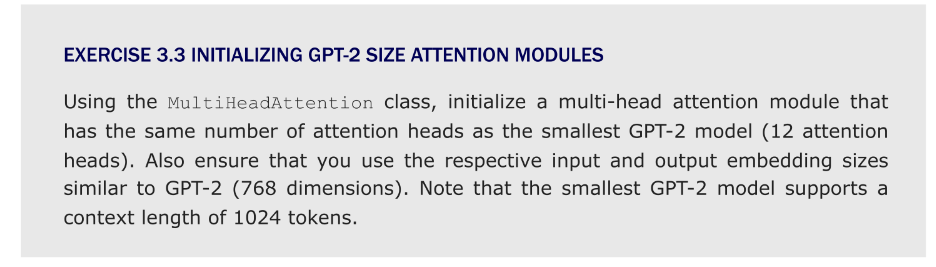

In [ ]:
d_in = 768
d_out = d_in
num_heads = 12

context_length = 1024

# self.d_out = d_out
# self.num_heads = num_heads
# self.head_dim = d_out // num_heads -> ogni attention-head calcolera un nuovo embedding a 64 dimensioni

gpt2_mha = MultiHeadAttention(d_in, d_out, context_length, 0.1, num_heads=num_heads)